In [1]:
import sys, os
import pandas as pd
import numpy as np
import seaborn as sns
profit_path = os.path.abspath(os.path.join('..'))
sys.path.append(profit_path)
from profit import NaivePortfolio, Strategy, Future, Backtest, Perfomance, Optimizer
%load_ext autoreload
%autoreload 2
%pylab inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

Populating the interactive namespace from numpy and matplotlib


In [2]:
store = pd.HDFStore('tests/sih5.h5', complevel=9, complib='blosc')
store

<class 'pandas.io.pytables.HDFStore'>
File path: tests/sih5.h5
/sih5_sec              frame_table  (typ->appendable,nrows->2920322,ncols->3,indexers->[index]) 
/sih5_ticks            frame_table  (typ->appendable,nrows->30744566,ncols->4,indexers->[index])

<b>SIH5, resampled by seconds</b>

In [3]:
data = store.select('sih5_sec')
store.close()
data.head(5)

price           timestamp ticker
0  63000 2014-12-16 10:00:00   sih5
1  62001 2014-12-16 10:00:01   sih5
2  62001 2014-12-16 10:00:02   sih5
3  62048 2014-12-16 10:00:03   sih5
4  62000 2014-12-16 10:00:04   sih5

<b>Strategy</b>

In [4]:
keys = ['atr_av', 'atr_st', 'k', 'sd', 'atr_bar']
vals = [5, 15, 3, 0.9, '30S']
param = dict(zip(keys, vals))

In [5]:
from profit.helpers import ATR
from atr_delta_hedger import atr_delta_hedger

class ATRDeltaHedger(Strategy):
    def __init__(self, p):
        self.p = p
        self.period_type = 'intraday'
        
    def generate_signals(self, data):
        idx = data.index
        data.index = data.timestamp
        ohlc = data.price.resample(self.p['atr_bar'], how='ohlc').dropna()
        atr = pd.Series(ATR(ohlc, self.p['atr_av']), index=data.index).fillna(method='pad')
        return pd.Series(atr_delta_hedger(atr.values, data.price.values, self.p['atr_st'], self.p['k'], self.p['sd']), index=idx)

In [6]:
instrs = [Future('sih5', slippage=0, min_step=1, step_price=1, comission=0.5)]
strategy = ATRDeltaHedger(param)
port = NaivePortfolio(order_size=1)
bt = Backtest(instrs, data, strategy, port)

Initializing data...Done.


<b>Optimization</b>

In [7]:
keys = ['atr_av', 'atr_st', 'k', 'sd', 'atr_bar']
opt_vals = [[3,4,5], [10,20,30,40,50], [3,4,5], [0.2, 0.4, 0.6, 0.8], ['15S','30S', '45S', '1Min']]
opt_param = dict(zip(keys, opt_vals))
opt = Optimizer(bt, opt_param, opt_f=('pnl','total'))
opt.params

atr_st  k atr_bar   sd  atr_av
0        10  3     15S  0.2       3
1        10  3     15S  0.2       4
2        10  3     15S  0.2       5
3        10  3     15S  0.4       3
4        10  3     15S  0.4       4
5        10  3     15S  0.4       5
6        10  3     15S  0.6       3
7        10  3     15S  0.6       4
8        10  3     15S  0.6       5
9        10  3     15S  0.8       3
10       10  3     15S  0.8       4
11       10  3     15S  0.8       5
12       10  3     30S  0.2       3
13       10  3     30S  0.2       4
14       10  3     30S  0.2       5
15       10  3     30S  0.4       3
16       10  3     30S  0.4       4
17       10  3     30S  0.4       5
18       10  3     30S  0.6       3
19       10  3     30S  0.6       4
20       10  3     30S  0.6       5
21       10  3     30S  0.8       3
22       10  3     30S  0.8       4
23       10  3     30S  0.8       5
24       10  3     45S  0.2       3
25       10  3     45S  0.2       4
26       10  3     45S  0.2       5
27       10  3     45S  0.4       3
28       10  3     45S  0.4       4
29       10  3     45S  0.4       5
..      ... ..     ...  ...     ...
690      50  5     30S  0.6       3
691      50  5     30S  0.6       4
692      50  5     30S  0.6       5
693      50  5     30S  0.8       3
694      50  5     30S  0.8       4
695      50  5     30S  0.8       5
696      50  5     45S  0.2       3
697      50  5     45S  0.2       4
698      50  5     45S  0.2       5
699      50  5     45S  0.4       3
700      50  5     45S  0.4       4
701      50  5     45S  0.4       5
702      50  5     45S  0.6       3
703      50  5     45S  0.6       4
704      50  5     45S  0.6       5
705      50  5     45S  0.8       3
706      50  5     45S  0.8       4
707      50  5     45S  0.8       5
708      50  5    1Min  0.2       3
709      50  5    1Min  0.2       4
710      50  5    1Min  0.2       5
711      50  5    1Min  0.4       3
712      50  5    1Min  0.4       4
713      50  5    1Min  0.4       5
714      50  5    1Min  0.6       3
715      50  5    1Min  0.6       4
716      50  5    1Min  0.6       5
717      50  5    1Min  0.8       3
718      50  5    1Min  0.8       4
719      50  5    1Min  0.8       5

[720 rows x 5 columns]

In [8]:
opt.run()

Begin optimization at 2015-05-06 06:31:31.895282
Running backtest #1 from 720...
Running backtest #2 from 720...
Running backtest #3 from 720...
Running backtest #4 from 720...
Running backtest #5 from 720...
Running backtest #6 from 720...
Running backtest #7 from 720...
Running backtest #8 from 720...
Running backtest #9 from 720...
Running backtest #10 from 720...
Running backtest #11 from 720...
Running backtest #12 from 720...
Running backtest #13 from 720...
Running backtest #14 from 720...
Running backtest #15 from 720...
Running backtest #16 from 720...
Running backtest #17 from 720...
Running backtest #18 from 720...
Running backtest #19 from 720...
Running backtest #20 from 720...
Running backtest #21 from 720...
Running backtest #22 from 720...
Running backtest #23 from 720...
Running backtest #24 from 720...
Running backtest #25 from 720...
Running backtest #26 from 720...
Running backtest #27 from 720...
Running backtest #28 from 720...
Running backtest #29 from 720...
Run

In [20]:
opt.params['pnl'] = opt.result
opt.params.sort(columns='pnl', ascending=False)

atr_st  k atr_bar   sd  atr_av           pnl
384      30  5     15S  0.2       3       3342142
288      30  3     15S  0.2       3       3225678
336      30  4     15S  0.2       3       3184168
600      50  3     45S  0.2       3       2668746
696      50  5     45S  0.2       3       2627596
648      50  4     45S  0.2       3       2550770
291      30  3     15S  0.4       3       1423680
603      50  3     45S  0.4       3       1302134
339      30  4     15S  0.4       3       1171714
651      50  4     45S  0.4       3       1077552
387      30  5     15S  0.4       3       1074316
699      50  5     45S  0.4       3       1056408
294      30  3     15S  0.6       3        735408
0        10  3     15S  0.2       3        677512
342      30  4     15S  0.6       3        660704
390      30  5     15S  0.6       3        600030
609      50  3     45S  0.8       3        572164
386      30  5     15S  0.2       5        564276
96       10  5     15S  0.2       3        561434
606      50  3     45S  0.6       3        552324
297      30  3     15S  0.8       3        546750
1        10  3     15S  0.2       4        534456
657      50  4     45S  0.8       3        494164
705      50  5     45S  0.8       3        489282
48       10  4     15S  0.2       3        488588
654      50  4     45S  0.6       3        460630
97       10  5     15S  0.2       4        458624
345      30  4     15S  0.8       3        452698
290      30  3     15S  0.2       5        434018
338      30  4     15S  0.2       5        425724
..      ... ..     ...  ...     ...           ...
580      50  3     15S  0.4       4  -1.11518e+08
676      50  5     15S  0.4       4 -1.117096e+08
628      50  4     15S  0.4       4 -1.117376e+08
582      50  3     15S  0.6       3 -1.338619e+08
678      50  5     15S  0.6       3 -1.339487e+08
630      50  4     15S  0.6       3 -1.339619e+08
579      50  3     15S  0.4       3 -1.498563e+08
627      50  4     15S  0.4       3 -1.499359e+08
675      50  5     15S  0.4       3 -1.499855e+08
584      50  3     15S  0.6       5 -1.904345e+08
680      50  5     15S  0.6       5 -1.905032e+08
632      50  4     15S  0.6       5 -1.905648e+08
686      50  5     30S  0.2       5 -2.146895e+08
590      50  3     30S  0.2       5 -2.147268e+08
638      50  4     30S  0.2       5 -2.147529e+08
581      50  3     15S  0.4       5 -2.159367e+08
677      50  5     15S  0.4       5 -2.160435e+08
629      50  4     15S  0.4       5 -2.160476e+08
530      40  5     15S  0.2       5 -2.215682e+08
482      40  4     15S  0.2       5 -2.217936e+08
434      40  3     15S  0.2       5 -2.218808e+08
673      50  5     15S  0.2       4 -2.226343e+08
625      50  4     15S  0.2       4  -2.22706e+08
577      50  3     15S  0.2       4 -2.228408e+08
672      50  5     15S  0.2       3 -2.992094e+08
624      50  4     15S  0.2       3 -2.992284e+08
576      50  3     15S  0.2       3 -2.992982e+08
674      50  5     15S  0.2       5 -4.316753e+08
626      50  4     15S  0.2       5 -4.318208e+08
578      50  3     15S  0.2       5 -4.318289e+08

[720 rows x 6 columns]

In [21]:
opt.params.to_excel('optimized_pnl.xlsx')

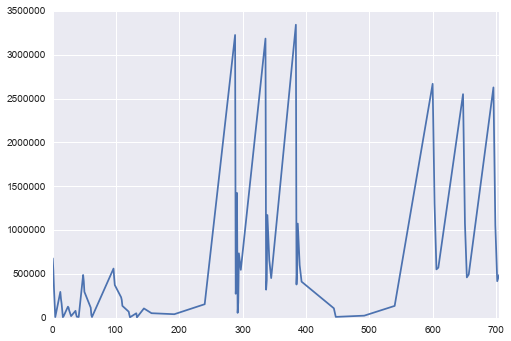

In [22]:
opt.params[opt.params.pnl>0].pnl.plot()

<b>9 peaks here, show them

In [24]:
opt_pnl_params = opt.params.sort(columns='pnl', ascending=False).head(9)
opt_pnl_params

atr_st  k atr_bar   sd  atr_av      pnl
384      30  5     15S  0.2       3  3342142
288      30  3     15S  0.2       3  3225678
336      30  4     15S  0.2       3  3184168
600      50  3     45S  0.2       3  2668746
696      50  5     45S  0.2       3  2627596
648      50  4     45S  0.2       3  2550770
291      30  3     15S  0.4       3  1423680
603      50  3     45S  0.4       3  1302134
339      30  4     15S  0.4       3  1171714

<b>Optimize these 9 by best Sharpe

In [34]:
# keys = ['atr_av', 'atr_st', 'k', 'sd', 'atr_bar']
# opt_vals = [[3], [30,50], [3,4,5], [0.2, 0.4], ['15S', '45S']]
# opt_params_sharpe = dict(zip(keys, opt_vals))
opt_params_sharpe={}
opt_sharpe = Optimizer(bt, opt_params_sharpe, opt_f=('sharpe','total'))
opt_sharpe.params = opt_pnl_params[['atr_av', 'atr_st', 'k', 'sd', 'atr_bar']]
opt_sharpe.params.index = np.arange(len(opt_sharpe.params))

In [35]:
opt_sharpe.run()

Begin optimization at 2015-05-06 12:38:19.582744
Running backtest #1 from 9...
Running backtest #2 from 9...
Running backtest #3 from 9...
Running backtest #4 from 9...
Running backtest #5 from 9...
Running backtest #6 from 9...
Running backtest #7 from 9...
Running backtest #8 from 9...
Running backtest #9 from 9...
Optimizing end in 0h 4min 48sec for 5 parameters.



In [53]:
opt_sharpe.params['sharpe'] = opt_sharpe.result
optimized_sharpe = opt_sharpe.params.sort(columns='sharpe', ascending=False)
optimized_sharpe.to_excel('optimized_sharpe.xlsx')
optimized_sharpe

atr_av  atr_st  k   sd atr_bar     sharpe
1       3      30  3  0.2     15S  0.2269211
2       3      30  4  0.2     15S  0.2240121
6       3      30  3  0.4     15S  0.2003161
8       3      30  4  0.4     15S  0.1648663
3       3      50  3  0.2     45S  0.1579397
4       3      50  5  0.2     45S  0.1555075
7       3      50  3  0.4     45S  0.1541241
5       3      50  4  0.2     45S  0.1509591
0       3      30  5  0.2     15S -0.1654454

<b>Runstrategy with best optimized parameter

In [39]:
strategy.p = opt_sharpe.params.ix[1, ['atr_av', 'atr_st', 'k', 'sd', 'atr_bar']].to_dict()

In [41]:
bt.run()

Backtesting begin at 2015-05-06 12:48:18.917112
Generating signals...Done.
Generating orders...Done.
Simulating market execution...Done.
Calculating positions...Done.
Backtesting done in 0h 0min 39sec for 2920322 data rows.



<b>Statistics

In [42]:
perf = Perfomance(bt.data)

In [43]:
perf.total

VALUE
Days traded            59
First day      2014-12-16
Last day       2015-03-16
loss_amount      -8600570
loss_count         185116
maxdd              540792
payoff           1.490308
pf               1.375192
pnl               3226864
rf               5.966923
sharpe          0.2270045
trades             716496
win_amount   1.182743e+07
win_count          170817
winrate         0.4799134

In [44]:
perf.periodic

loss_amount  loss_count   maxdd    payoff        pf      pnl  \
2014-12-16      -332040        3401   11048  1.114905  1.050325    16710   
2014-12-17      -346260        4137   10236  1.198341  1.113470    39290   
2014-12-18      -273216        3936    5100  1.142145  1.113998    31146   
2014-12-19      -173794        3725    4082  1.189101  1.145368    25264   
2014-12-22      -267824        3664   93626  0.801414  0.755481   -65488   
2014-12-23      -189982        3737   12512  1.044001  0.990641    -1778   
2014-12-24      -129162        3464    3484  1.131755  1.083074    10730   
2014-12-25      -146342        3083   14074  1.020284  1.033852     4954   
2014-12-26      -144062        3245   10532  1.028418  0.961864    -5494   
2014-12-29      -163514        3587    5956  1.132437  1.063297    10350   
2014-12-30      -187304        3329    7398  1.117188  1.083629    15664   
2015-01-05      -150670        3476    6548  1.142583  1.086374    13014   
2015-01-06      -186404        3710    8272  1.081471  1.035997     6710   
2015-01-08      -181332        3820   10108  1.129892  1.063045    11432   
2015-01-09      -155780        3531    5848  1.074857  1.058724     9148   
2015-01-12      -117246        3316    7072  1.107340  0.993467     -766   
2015-01-13      -138700        3140   14318  0.950452  0.909589   -12540   
2015-01-14      -113702        3016   11334  1.051716  0.976394    -2684   
2015-01-15      -147002        3553    7596  1.052170  1.000939      138   
2015-01-16      -116998        3335    8110  1.047838  1.011077     1296   
2015-01-19      -133380        2736   20776  0.973446  0.902999   -12938   
2015-01-20       -54906        2087    7948  1.057672  0.902087    -5376   
2015-01-21      -103460        3210   15858  0.946652  0.851691   -15344   
2015-01-22      -122960        3050   19336  0.949472  0.856392   -17658   
2015-01-23      -107870        2720    8810  1.109403  1.021711     2342   
2015-01-26      -112908        2872   12926  1.070039  0.947834    -5890   
2015-01-27      -124144        3498   12302  1.027751  0.935494    -8008   
2015-01-28       -92804        2683    9608  1.013812  0.919723    -7450   
2015-01-29      -139232        3238   20318  0.960533  0.905654   -13136   
2015-01-30      -129790        2865   11980  1.008620  0.915679   -10944   
2015-02-02      -154356        3379   22884  0.927113  0.860440   -21542   
2015-02-03      -132188        3369   18404  0.967318  0.890656   -14454   
2015-02-04      -180052        3699   15424  1.010696  0.962333    -6782   
2015-02-05      -156158        3709    8604  1.144759  1.127166    19858   
2015-02-06      -140196        3562    6388  1.102238  0.993623     -894   
2015-02-09      -132286        3651   12402  1.045772  0.953540    -6146   
2015-02-10      -143262        3459   32474  0.947493  0.794098   -29498   
2015-02-11      -129944        3694   20788  0.971325  0.865357   -17496   
2015-02-12      -141118        3682   12294  1.063310  0.991114    -1254   
2015-02-13      -144216        3361   31094  0.912490  0.800092   -28830   
2015-02-16       -99044        3037    6924  1.116083  1.068677     6802   
2015-02-17      -121658        2954   15060  0.960131  0.897401   -12482   
2015-02-18      -107924        2824   13970  1.004902  0.878933   -13066   
2015-02-19      -131678        3307   27934  0.892279  0.798114   -26584   
2015-02-20      -120352        3589   17952  0.953216  0.888411   -13430   
2015-02-24      -102966        2809   11898  1.020658  0.939631    -6216   
2015-02-25       -97502        2527   18944  1.203748  1.062747     6118   
2015-02-26      -100362        2254   25694  0.900276  0.753692   -24720   
2015-02-27      -103584        2886   18944  0.939457  0.831383   -17466   
2015-03-02       -76154        2278   19048  0.868646  0.752344   -18860   
2015-03-03       -78688        2669   20790  0.879914  0.770461   -18062   
2015-03-04       -58358        2631   12132  0.966317  0.823

In [45]:
perf.periodic_stat

loss_amount   loss_count          maxdd     payoff         pf  \
count      59.000000    59.000000      59.000000  59.000000  59.000000   
mean  -145772.372881  3137.559322   21033.796610   1.155996   1.051439   
std     77520.323382   584.177296   43516.106153   1.054945   0.860472   
min   -549226.000000   600.000000    1674.000000   0.778402   0.717665   
25%   -152513.000000  2816.500000    8438.000000   0.951834   0.862898   
50%   -131678.000000  3245.000000   12402.000000   1.027751   0.947834   
75%   -107897.000000  3557.500000   19192.000000   1.104789   1.034925   
max    -23708.000000  4137.000000  335000.000000   9.089029   7.496553   

                  pnl         rf     sharpe        trades      win_amount  \
count       59.000000  59.000000  59.000000     59.000000       59.000000   
mean     54692.610169   0.296068  -1.156573  12144.000000   200464.983051   
std     465597.172443   2.095970   3.133422   2245.399726   522653.173420   
min     -65488.000000  -0.990130  -6.288258   2344.000000    23160.000000   
25%     -14899.000000  -0.858147  -3.539892  10811.500000   104357.000000   
50%      -6216.000000  -0.522441  -2.042526  12628.000000   117734.000000   
75%       5536.000000   0.337474   0.947508  13917.000000   157490.000000   
max    3568076.000000  10.650973   6.666850  15122.000000  4117302.000000   

         win_count    winrate  
count    59.000000  59.000000  
mean   2895.203390   0.478832  
std     599.628586   0.010921  
min     558.000000   0.451992  
25%    2542.000000   0.471650  
50%    2975.000000   0.481331  
75%    3322.000000   0.486692  
max    3844.000000   0.503303

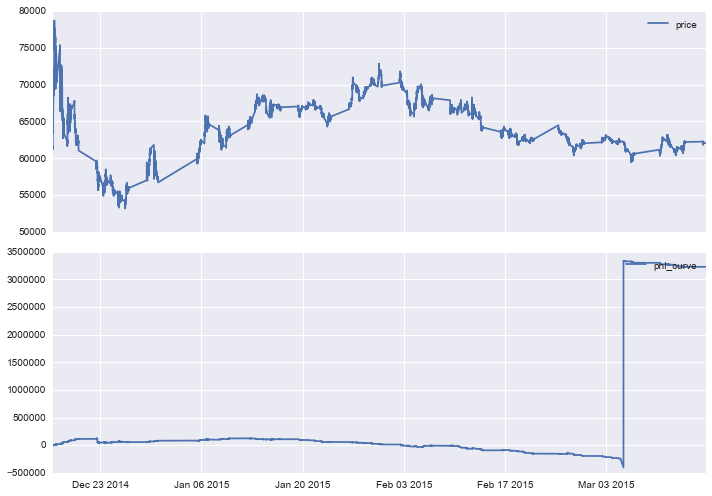

In [46]:
perf.show_day('all')

In [47]:
perf.show_day(('best', 'pnl'))

2015-03-05


2014-12-22


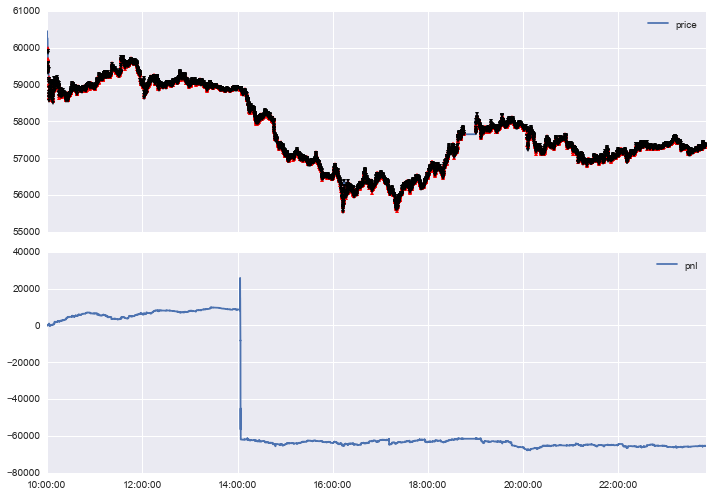

In [48]:
perf.show_day(('worst', 'pnl'))

2014-12-25


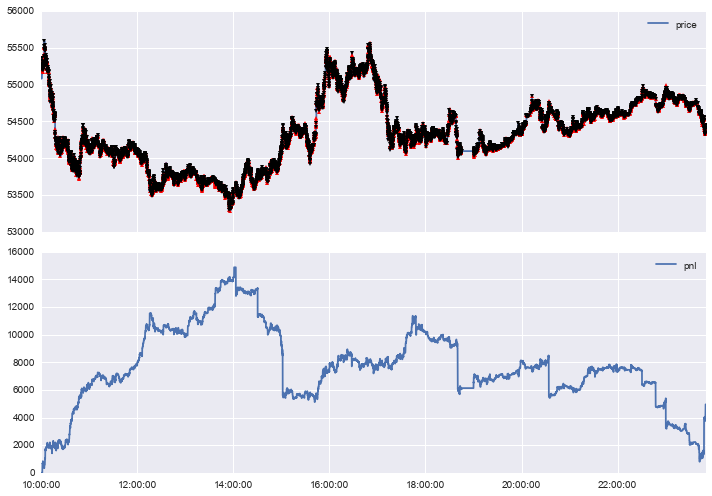

In [49]:
perf.show_day(('best', 'winrate'))

2015-03-05


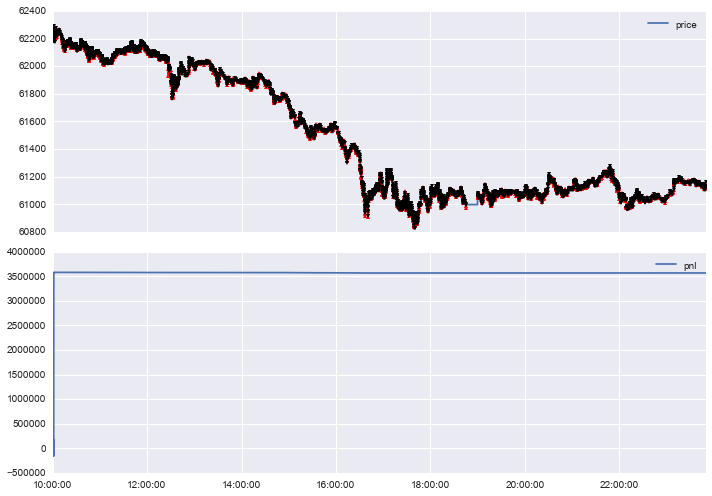

In [50]:
perf.show_day(('worst', 'winrate'))

In [51]:
perf.show_day(('best', 'sharpe'))

2014-12-19


2015-01-22


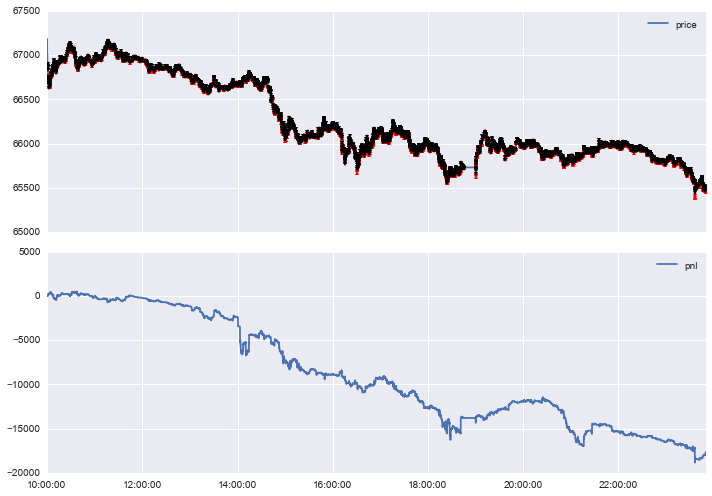

In [52]:
perf.show_day(('worst', 'sharpe'))